<a href="https://colab.research.google.com/github/JakobPorsfelt/Content-Analysis/blob/main/Exam_CV_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Facial Expressions using Huggingface

####The scenario is a research on comparing textual sentiments in social media with image media. In this case a model is needed that can predict a given emotional expression in a picture.
####Studies indicate that Facial expression recognition can be used for sentiment analysis(Jayalekshmi & Mathew 2017)
####It is finetuned on a widely availabe dataset by Yousif Khaireddin and Zhuofa Chen called FER-2013 with approximately 30 thousand RGB images of emotions divided into 7 types: Angry, Disgust, Fear, Happy, Sad, Surprise,Neutral.(Khaireddin & Chen 2021)
####To this end, this code uses a model by huggingface user Tr Pakov - it is a finetuned model that uses the widely known transformer model Vision Transformer (ViT) - ViT stands for Vision Transformer and are inspired by transformers found in NLP. They operate in similar manner, and their main strength over CNN for an example, is their ability of self attention, which allows the transformer to weigh parts of the input differently (Szeliski 2022)
####The predictions are run on a new dataset unknown to the model from Kaggle "Facial Emotion Recognition Dataset" containing 153 images with 7 distinct emotions (anger, contempt, disgust, fear, happiness, sadness and surprise)
#### Predictions are run on all, but emphasis on emotions corresponding to the labels during the finetuning of the model which is Anger (Angry), Disgust, Happiness (Happy), Sadness (Sad) and Surprise.

In [1]:
!pip install transformers datasets gdown==4.6 evaluate accelerate
!pip install --upgrade tensorflow
!pip install transformers[torch]
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [2]:
from transformers import DefaultDataCollator
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import accelerate
import transformers
from transformers import TrainingArguments, Trainer

In [3]:
#downloading the dataset
import gdown

!gdown --fuzzy https://drive.google.com/uc?id=10LfN1-_9gFqD9mEZyxFz_acJQ_bOvpEw

Downloading...
From: https://drive.google.com/uc?id=10LfN1-_9gFqD9mEZyxFz_acJQ_bOvpEw
To: /content/emotions.zip
100% 454M/454M [00:06<00:00, 70.8MB/s]


In [4]:
!unzip "/content/emotions.zip" -d "/content/dataset"

Archive:  /content/emotions.zip
   creating: /content/dataset/Images_second_dataset/test/
   creating: /content/dataset/Images_second_dataset/test/13/
  inflating: /content/dataset/Images_second_dataset/test/13/Anger.jpg  
  inflating: /content/dataset/Images_second_dataset/test/13/Contempt.jpg  
  inflating: /content/dataset/Images_second_dataset/test/13/Disgust.jpg  
  inflating: /content/dataset/Images_second_dataset/test/13/Fear.jpg  
  inflating: /content/dataset/Images_second_dataset/test/13/Happy.jpg  
  inflating: /content/dataset/Images_second_dataset/test/13/Neutral.jpg  
  inflating: /content/dataset/Images_second_dataset/test/13/Sad.jpg  
  inflating: /content/dataset/Images_second_dataset/test/13/Surprised.jpg  
   creating: /content/dataset/Images_second_dataset/test/14/
  inflating: /content/dataset/Images_second_dataset/test/14/Anger.jpg  
  inflating: /content/dataset/Images_second_dataset/test/14/Contempt.jpg  
  inflating: /content/dataset/Images_second_dataset/test/

In [5]:
import os
import shutil

def consolidate_images(source_dir, target_dir):
    """
    The problem with the dataset is the initial folder structure. it is divided into identities, with images named after their labeling -
    i.e sad for image depicting a sad face and so on. This is problematic because the goal is to run predictions on all images of a given emotion.
    Therefore this script renamed the images by giving them a number in addition to their label. It also places all the images in the same folder.
    So in short it consolidates the images from the various subfolders into a single folder giving them unique names.

    - source_dir: Directory with subfolders containing the images.
    - target_dir: Directory where the consolidated images will be stored.
    """
    # Create the target directory if it doesn't exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Initialize a counter for each emotion to create unique filenames
    counters = {
        'Anger': 0,
        'Contempt': 0,
        'Disgust': 0,
        'Fear': 0,
        'Happy': 0,
        'Neutral': 0,
        'Sad': 0,
        'Surprised': 0
    }

    # Walk through the source directory
    for subdir, _, files in os.walk(source_dir):
        for file in files:
            # Create a new filename based on the emotion and counter
            file_emotion = file.replace('.jpg', '')
            counters[file_emotion] += 1
            new_filename = f"{file_emotion}_{counters[file_emotion]}.jpg"
            new_filepath = os.path.join(target_dir, new_filename)

            # Copy the file to the new location with the new name
            shutil.copy(os.path.join(subdir, file), new_filepath)

    print("Consolidation complete.")

# Path to the source directory
source_directory = '/content/dataset/Images_second_dataset'  # Replace with your dataset path
# Path to the target directory
target_directory = '/content/consolidated_images'  # Replace with your desired path

# Run the function to start consolidation
consolidate_images(source_directory, target_directory)


Consolidation complete.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Emotion: Happy
  Matches: 18
  Non-matches: 1
  Match Percentage: 94.74%
  Non-Match Percentage: 5.26%
Emotion: Sad
  Matches: 6
  Non-matches: 13
  Match Percentage: 31.58%
  Non-Match Percentage: 68.42%
Emotion: Anger
  Matches: 0
  Non-matches: 19
  Match Percentage: 0.00%
  Non-Match Percentage: 100.00%
Emotion: Fear
  Matches: 1
  Non-matches: 18
  Match Percentage: 5.26%
  Non-Match Percentage: 94.74%
Emotion: Disgust
  Matches: 0
  Non-matches: 19
  Match Percentage: 0.00%
  Non-Match Percentage: 100.00%
Emotion: Surprised
  Matches: 0
  Non-matches: 19
  Match Percentage: 0.00%
  Non-Match Percentage: 100.00%
Emotion: Neutral
  Matches: 14
  Non-matches: 5
  Match Percentage: 73.68%
  Non-Match Percentage: 26.32%


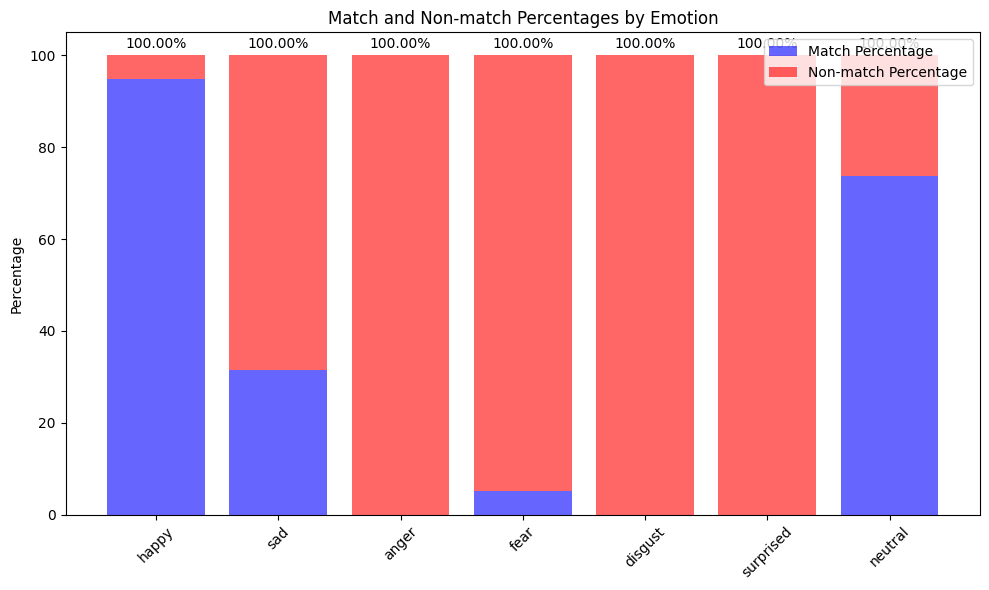

In [14]:
from transformers import pipeline
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# Initialize the pipeline, and does necessary preprocessing of the images to fit the expected input of the model.
model_name = "trpakov/vit-face-expression"
pipe = pipeline("image-classification", model=model_name)


'''
This function takes in a folder path, emotion and pipeline as defined above.
then runs prediction using model from huggingface on images containing a filename that corresponds to that emotion.
Notice that the predictions are probabilities, with the highest printed first.
'''


def run_predictions_on_all_images(image_dir, pipe):
    predictions = {}
    # Walk through the image_dir
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    # Load the image
                    image_path = os.path.join(root, file)
                    image = Image.open(image_path)

                    # Make prediction
                    result = pipe(image)

                    # Store the predictions
                    predictions[file] = result

                    # Close the image file to free up system resources
                    image.close()
                except Exception as e:
                    print(f"An error occurred while processing image: {image_path}. Error: {e}")
    return predictions



"""
This next function takes the highest prediction score(from the prediction dictionary created above) as the prediction for that image,
then counts that result. It compares this prediction with the image file name, and counts if there is a match or not.
It finally shows a list of matches vs non-matches and checks if there is more matches or non-matches.
"""

def count_matches_by_emotion(predictions):
    results = {emotion: {'matches': 0, 'non_matches': 0, 'match_percentage': 0, 'non_match_percentage': 0} for emotion in emotions}

    for image_name, prediction in predictions.items():
        if prediction:  # Check if there is at least one prediction
            highest_score_emotion = prediction[0]['label'].lower()  # The emotion with the highest score
            true_emotion = image_name.split('_')[0].lower()  # Assumes true emotion is before the first underscore

            if true_emotion in results:
                if true_emotion == highest_score_emotion:
                    results[true_emotion]['matches'] += 1
                else:
                    results[true_emotion]['non_matches'] += 1

                # Calculate percentages
                total = results[true_emotion]['matches'] + results[true_emotion]['non_matches']
                results[true_emotion]['match_percentage'] = (results[true_emotion]['matches'] / total) * 100 if total > 0 else 0
                results[true_emotion]['non_match_percentage'] = (results[true_emotion]['non_matches'] / total) * 100 if total > 0 else 0

    return results


emotions = ['happy', 'sad', 'anger', 'fear', 'disgust', 'surprised', 'neutral']

# Run predictions on all images
image_directory = '/content/consolidated_images'
all_predictions = run_predictions_on_all_images(image_directory, pipe)

# Count matches by emotion
emotion_results = count_matches_by_emotion(all_predictions)

# Print the results
for emotion, counts in emotion_results.items():
    print(f"Emotion: {emotion.capitalize()}")
    print(f"  Matches: {counts['matches']}")
    print(f"  Non-matches: {counts['non_matches']}")
    print(f"  Match Percentage: {counts['match_percentage']:.2f}%")
    print(f"  Non-Match Percentage: {counts['non_match_percentage']:.2f}%")



#Finally visualizing the results from above as a percentage(match or non-matches) in a bar chart.

import matplotlib.pyplot as plt

def visualize_results(emotion_results):
    emotions = list(emotion_results.keys())
    match_percentages = [emotion_results[emotion]['match_percentage'] for emotion in emotions]
    non_match_percentages = [emotion_results[emotion]['non_match_percentage'] for emotion in emotions]

    # Calculate the total percentage for matches and non-matches
    total_percentages = [mp + nmp for mp, nmp in zip(match_percentages, non_match_percentages)]

    # Plotting match and non-match percentages
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(emotions, match_percentages, label='Match Percentage', alpha=0.6, color='blue')
    ax.bar(emotions, non_match_percentages, bottom=match_percentages, label='Non-match Percentage', alpha=0.6, color='red')

    ax.set_ylabel('Percentage')
    ax.set_title('Match and Non-match Percentages by Emotion')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Displaying the exact percentage above bars
    for i, emotion in enumerate(emotions):
        ax.text(i, total_percentages[i] + 1, f'{total_percentages[i]:.2f}%', ha='center', va='bottom')

    plt.show()

# Visualize the results
visualize_results(emotion_results)

####The model obviously does a rather bad job at predicting everything but happy and more or less neutral. It could indicate that the finetuning suffers from overfitting, it could also be that my dataset is not good data. It is unclear on Huggingface how the finetuning occured, and greater resources to finetune the model myself would have been ideal, but too great in scope for this assignement. Further finetuning would suffer from the fact that the dataset is so small that it would not yield good results, also it would take too long in the given enviroment. All in all, it would be advisable to finetune with a bigger dataset, or use a different model altogether.